<a href="https://colab.research.google.com/github/lunaB/AI-Experiment/blob/master/gan_font__interpolation_%EC%99%84%EC%84%B1%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REF
- https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
- https://realblack0.github.io/2020/05/11/transpose-convolution.html
- https://hyunlee103.tistory.com/63
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://stackoverflow.com/questions/62133737/how-does-pytorchs-loss-backward-work-when-retain-graph-true-is-specified (detach)
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795

In [1]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import pickle


# draw
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color=255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)

    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    # 해당 font에 글자 없을시
    if flag == 255 * 128 * 128:
        print('[warning] 폰트 없음 :', ch)
        return None

    if w>canvas_size or h>canvas_size:
        print('[warning] 사이즈를 맞춰주세요')

    return image

# ttf to pickle
def ttf_to_pkl(text, font_path, pkl_path, canvas_size=128, font_size=90):
    font = ImageFont.truetype(font=font_path, size=font_size)

    text_img = []

    for i in text:
        img = draw_single_char(i, font, canvas_size)
        text_img.append(np.array(img))

    with open(pkl_path, 'wb') as f:
        pickle.dump(text_img, f)

    # print(np.array(text_img).shape)
    # plt.imshow(text_img[0], cmap='gray')
    # plt.show()

In [2]:
def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        cs = 64

        # in, out, k, s, p, d
        self.e1 = nn.Sequential(
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8)
        )
        self.e7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            # nn.BatchNorm2d(cs*8)
        )

        self.e1.apply(init_weights)
        self.e2.apply(init_weights)
        self.e3.apply(init_weights)
        self.e4.apply(init_weights)
        self.e5.apply(init_weights)
        self.e6.apply(init_weights)
        self.e7.apply(init_weights)

    def forward(self, x):
        d = dict()
        x = self.e1(x)
        d['e1'] = x
        x = self.e2(x)
        d['e2'] = x
        x = self.e3(x)
        d['e3'] = x
        x = self.e4(x)
        d['e4'] = x
        x = self.e5(x)
        d['e5'] = x
        x = self.e6(x)
        d['e6'] = x
        x = self.e7(x)
        d['e7'] = x
        return x, d

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        cs = 64

        # 128 = style vector
        self.d1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8+128, cs*8, 3, 1, 1), # e1이랑 합치기위해 유지
            # nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*4, cs, 4, 2, 1),
            nn.BatchNorm2d(cs),
        )
        self.d8 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*2, 1, 4, 2, 1),
            # nn.BatchNorm2d(cs),
            # nn.LeakyReLU(0.2),
            # nn.Sigmoid(),
            nn.Tanh(),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.d5.apply(init_weights)
        self.d6.apply(init_weights)
        self.d7.apply(init_weights)
        self.d8.apply(init_weights)

    def forward(self, x, e):
        x = self.d1(x)
        x = torch.cat((x, e['e7']), dim=1)
        x = self.d2(x)
        x = torch.cat((x, e['e6']), dim=1)
        x = self.d3(x)
        x = torch.cat((x, e['e5']), dim=1)
        x = self.d4(x)
        x = torch.cat((x, e['e4']), dim=1)
        x = self.d5(x)
        x = torch.cat((x, e['e3']), dim=1)
        x = self.d6(x)
        x = torch.cat((x, e['e2']), dim=1)
        x = self.d7(x)
        x = torch.cat((x, e['e1']), dim=1)
        x = self.d8(x)
        return x

# class Generator(nn.Module):
#     def __init__(self, En, De):
#         super(Generator, self).__init__()
#         self.En = En()
#         self.De = De()

#     def forward(self, x, vec):
#         x, d = self.En(x)
#         x = torch.cat((x, vec), dim=1)
#         x = self.De(x, d)
#         return x

class Discriminator(nn.Module):
    def __init__(self, category_num):
        super(Discriminator, self).__init__()
        cs = 64

        self.category_num = category_num

        self.d1 = nn.Sequential(
            # nn.LeakyReLU(0.2),
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.fc_tf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, 1),
        )
        self.fc_cg = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, category_num),
        )

        self.d1.apply(init_weights)
        self.d2.apply(init_weights)
        self.d3.apply(init_weights)
        self.d4.apply(init_weights)
        self.fc_tf.apply(init_weights)
        self.fc_cg.apply(init_weights)

    def forward(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)

        tf = self.fc_tf(x)
        cg = self.fc_cg(x)

        return tf, cg

In [4]:
upper = "A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z"
lower = "a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z"
# number = "0, 1, 2, 3, 4, 5, 6, 7, 8, 9"

# text = (upper+', '+lower+', '+number).split(", ")
text = (upper+', '+lower).split(", ")

ttf_to_pkl(text, 'NanumGothic-Regular.ttf', 'NanumGothic-Regular.pkl')
source = load_pkl('NanumGothic-Regular.pkl')
source = np.array(source)

ttf_to_pkl(text, 'Langar-Regular.ttf', 'Langar-Regular.pkl')
ttf_to_pkl(text, 'Audiowide-Regular.ttf', 'Audiowide-Regular.pkl')
t1 = load_pkl('Langar-Regular.pkl')
t2 = load_pkl('Audiowide-Regular.pkl')
target = np.array([t1, t2])
print(source.shape, target.shape)

(52, 128, 128) (2, 52, 128, 128)


# 데이터 전처리


In [44]:
from torch.utils.data import DataLoader, TensorDataset

def norm_img(img):
    return img / (255/2) - 1
def denorm_img(img):
    return ((img + 1) / 2).clamp(0, 1)

source_tensor = torch.FloatTensor(source)
target_tensor = torch.FloatTensor([t1, t2])

source_tensor = norm_img(source_tensor)
target_tensor = norm_img(target_tensor)


print(source_tensor.shape, target_tensor.shape)
print(source_tensor.max(), source_tensor.min())

cg_num = target_tensor.shape[0]
font_num = target_tensor.shape[1]

x_data = torch.FloatTensor(source_tensor).repeat(2, 1, 1).view((cg_num * font_num, 1, 128, 128))
t_data = torch.FloatTensor(target_tensor).view((cg_num * font_num, 1, 128, 128))
t_meta = torch.LongTensor([[j, i] for j in range(cg_num) for i in range(font_num)]) # [cg, font]
c_vec = np.random.normal(size=(cg_num, 128, 1, 1))

c_vec_t = torch.FloatTensor([c_vec[i] for i in range(cg_num) for _ in range(font_num)])

x_data = x_data.cuda()
t_data = t_data.cuda()
c_vec_t = c_vec_t.cuda()

print(x_data.shape)
print(t_meta.shape)
print(c_vec.shape)
print(c_vec_t.shape)

torch.Size([52, 128, 128]) torch.Size([2, 52, 128, 128])
tensor(1.) tensor(-1.)
torch.Size([104, 1, 128, 128])
torch.Size([104, 2])
(2, 128, 1, 1)
torch.Size([104, 128, 1, 1])


# 학습

batch_size: 30, category_num: 2, font_num: 52
epoch: 1/150	g_loss: 2294.094696	d_loss: 35.274923
epoch: 2/150	g_loss: 1705.762177	d_loss: 10.054479
epoch: 3/150	g_loss: 1502.781464	d_loss: 12.046707
epoch: 4/150	g_loss: 1376.924896	d_loss: 11.500046
epoch: 5/150	g_loss: 1298.432770	d_loss: 5.481713
epoch: 6/150	g_loss: 1221.744232	d_loss: 9.592349
epoch: 7/150	g_loss: 1154.543457	d_loss: 4.237610
epoch: 8/150	g_loss: 1086.960541	d_loss: 7.279065
epoch: 9/150	g_loss: 1033.477737	d_loss: 5.698101
epoch: 10/150	g_loss: 976.320068	d_loss: 6.041459
문자: w


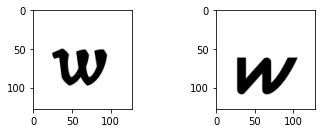

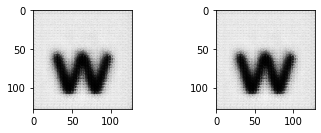

epoch: 11/150	g_loss: 925.845566	d_loss: 5.678366
epoch: 12/150	g_loss: 878.347626	d_loss: 4.274189
epoch: 13/150	g_loss: 836.766342	d_loss: 4.931853
epoch: 14/150	g_loss: 796.549469	d_loss: 3.876927
epoch: 15/150	g_loss: 758.059189	d_loss: 3.960593
epoch: 16/150	g_loss: 718.333939	d_loss: 4.214137
epoch: 17/150	g_loss: 687.290390	d_loss: 3.000126
epoch: 18/150	g_loss: 658.904099	d_loss: 3.662594
epoch: 19/150	g_loss: 628.775558	d_loss: 3.928318
epoch: 20/150	g_loss: 598.516388	d_loss: 2.980019
문자: g


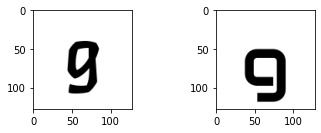

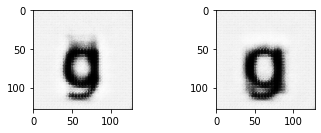

epoch: 21/150	g_loss: 576.223541	d_loss: 3.300172
epoch: 22/150	g_loss: 549.951599	d_loss: 3.809312
epoch: 23/150	g_loss: 522.477638	d_loss: 3.233533
epoch: 24/150	g_loss: 498.970230	d_loss: 3.281287
epoch: 25/150	g_loss: 477.884384	d_loss: 3.510786
epoch: 26/150	g_loss: 456.256332	d_loss: 3.726968
epoch: 27/150	g_loss: 431.025307	d_loss: 3.730141
epoch: 28/150	g_loss: 419.272354	d_loss: 2.872399
epoch: 29/150	g_loss: 391.403496	d_loss: 5.406204
epoch: 30/150	g_loss: 374.273582	d_loss: 4.313933
문자: Q


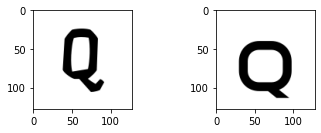

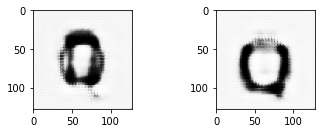

epoch: 31/150	g_loss: 358.165245	d_loss: 3.449972
epoch: 32/150	g_loss: 338.528374	d_loss: 3.897436
epoch: 33/150	g_loss: 320.843979	d_loss: 3.742839
epoch: 34/150	g_loss: 304.644524	d_loss: 4.353987
epoch: 35/150	g_loss: 291.905434	d_loss: 3.838313
epoch: 36/150	g_loss: 279.365746	d_loss: 3.538082
epoch: 37/150	g_loss: 263.735100	d_loss: 4.265007
epoch: 38/150	g_loss: 249.567055	d_loss: 3.432167
epoch: 39/150	g_loss: 235.420643	d_loss: 4.553843
epoch: 40/150	g_loss: 229.858921	d_loss: 3.678340
문자: I


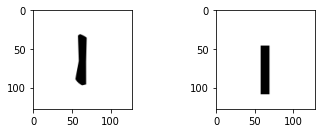

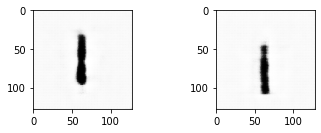

epoch: 41/150	g_loss: 217.440041	d_loss: 4.034605
epoch: 42/150	g_loss: 207.397957	d_loss: 5.519120
epoch: 43/150	g_loss: 198.872101	d_loss: 4.519653
epoch: 44/150	g_loss: 189.803555	d_loss: 3.793368
epoch: 45/150	g_loss: 177.764339	d_loss: 4.466165
epoch: 46/150	g_loss: 175.650417	d_loss: 3.924875
epoch: 47/150	g_loss: 165.235977	d_loss: 4.835303
epoch: 48/150	g_loss: 159.988045	d_loss: 3.801742
epoch: 49/150	g_loss: 151.754406	d_loss: 4.550597
epoch: 50/150	g_loss: 148.787098	d_loss: 4.738617
문자: V


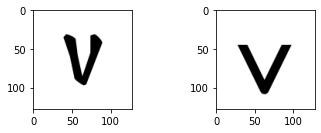

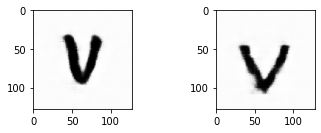

epoch: 51/150	g_loss: 141.614807	d_loss: 4.943457
epoch: 52/150	g_loss: 136.056210	d_loss: 4.073470
epoch: 53/150	g_loss: 132.047298	d_loss: 3.935964
epoch: 54/150	g_loss: 127.092594	d_loss: 4.508955
epoch: 55/150	g_loss: 122.214914	d_loss: 4.910938
epoch: 56/150	g_loss: 117.346657	d_loss: 4.935171
epoch: 57/150	g_loss: 114.419622	d_loss: 3.915300
epoch: 58/150	g_loss: 111.401583	d_loss: 5.204238
epoch: 59/150	g_loss: 109.719837	d_loss: 5.145470
epoch: 60/150	g_loss: 106.887003	d_loss: 4.899761
문자: y


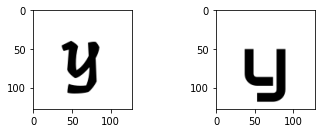

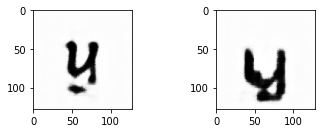

epoch: 61/150	g_loss: 103.976637	d_loss: 3.665988
epoch: 62/150	g_loss: 100.349245	d_loss: 7.284729
epoch: 63/150	g_loss: 97.736048	d_loss: 6.029783
epoch: 64/150	g_loss: 93.688522	d_loss: 5.781333
epoch: 65/150	g_loss: 88.502499	d_loss: 6.515304
epoch: 66/150	g_loss: 87.019060	d_loss: 4.762625
epoch: 67/150	g_loss: 82.741264	d_loss: 6.035126
epoch: 68/150	g_loss: 80.668402	d_loss: 4.371961
epoch: 69/150	g_loss: 77.077599	d_loss: 5.110850
epoch: 70/150	g_loss: 77.394274	d_loss: 4.368899
문자: n


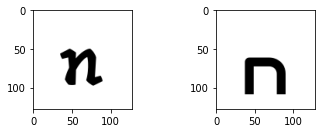

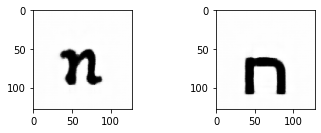

epoch: 71/150	g_loss: 73.052517	d_loss: 4.756213
epoch: 72/150	g_loss: 71.807291	d_loss: 4.109148
epoch: 73/150	g_loss: 69.022751	d_loss: 4.885796
epoch: 74/150	g_loss: 68.616076	d_loss: 4.347927
epoch: 75/150	g_loss: 69.238834	d_loss: 4.367794
epoch: 76/150	g_loss: 66.232529	d_loss: 5.024454
epoch: 77/150	g_loss: 67.466732	d_loss: 4.178004
epoch: 78/150	g_loss: 65.351582	d_loss: 4.392904
epoch: 79/150	g_loss: 62.104802	d_loss: 4.591921
epoch: 80/150	g_loss: 61.494836	d_loss: 4.257062
문자: e


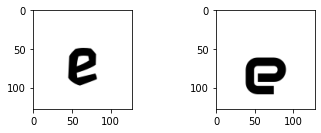

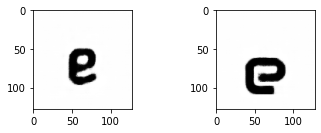

epoch: 81/150	g_loss: 58.899245	d_loss: 4.703695
epoch: 82/150	g_loss: 56.906033	d_loss: 4.358824
epoch: 83/150	g_loss: 55.859176	d_loss: 4.570469
epoch: 84/150	g_loss: 55.962779	d_loss: 3.928080
epoch: 85/150	g_loss: 52.902596	d_loss: 4.715762
epoch: 86/150	g_loss: 52.216731	d_loss: 5.128908
epoch: 87/150	g_loss: 50.923982	d_loss: 4.631689
epoch: 88/150	g_loss: 50.530779	d_loss: 4.407681
epoch: 89/150	g_loss: 50.497478	d_loss: 4.326521
epoch: 90/150	g_loss: 49.853359	d_loss: 4.916305
문자: k


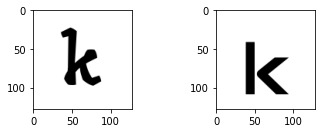

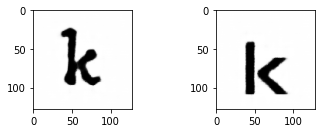

epoch: 91/150	g_loss: 48.893212	d_loss: 5.349280
epoch: 92/150	g_loss: 48.144069	d_loss: 4.823678
epoch: 93/150	g_loss: 47.780364	d_loss: 4.371832
epoch: 94/150	g_loss: 46.661295	d_loss: 5.828534
epoch: 95/150	g_loss: 46.364097	d_loss: 5.599999
epoch: 96/150	g_loss: 45.435570	d_loss: 5.039997
epoch: 97/150	g_loss: 42.674645	d_loss: 6.457366
epoch: 98/150	g_loss: 42.268197	d_loss: 4.976229
epoch: 99/150	g_loss: 42.726905	d_loss: 5.361871
epoch: 100/150	g_loss: 40.884351	d_loss: 6.509195
문자: z


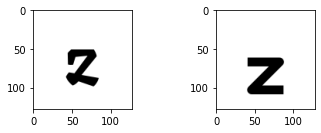

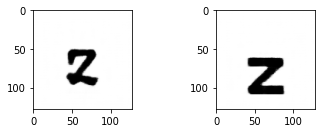

epoch: 101/150	g_loss: 41.478796	d_loss: 4.457845
epoch: 102/150	g_loss: 39.787101	d_loss: 6.052033
epoch: 103/150	g_loss: 39.447377	d_loss: 5.794674
epoch: 104/150	g_loss: 38.922137	d_loss: 4.590259
epoch: 105/150	g_loss: 37.917189	d_loss: 5.163163
epoch: 106/150	g_loss: 37.559757	d_loss: 4.630649
epoch: 107/150	g_loss: 37.356994	d_loss: 4.822599
epoch: 108/150	g_loss: 36.513924	d_loss: 4.959718
epoch: 109/150	g_loss: 36.070369	d_loss: 4.580433
epoch: 110/150	g_loss: 35.234040	d_loss: 4.711952
문자: g


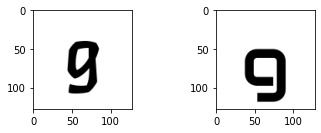

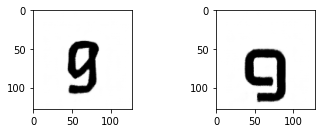

epoch: 111/150	g_loss: 35.514740	d_loss: 4.576096
epoch: 112/150	g_loss: 34.901890	d_loss: 4.521057
epoch: 113/150	g_loss: 34.270634	d_loss: 4.693679
epoch: 114/150	g_loss: 32.722314	d_loss: 4.573853
epoch: 115/150	g_loss: 32.286198	d_loss: 4.734629
epoch: 116/150	g_loss: 32.528310	d_loss: 4.722761
epoch: 117/150	g_loss: 32.194708	d_loss: 5.146667
epoch: 118/150	g_loss: 32.790013	d_loss: 4.945184
epoch: 119/150	g_loss: 31.882069	d_loss: 4.854746
epoch: 120/150	g_loss: 32.800505	d_loss: 5.148164
문자: F


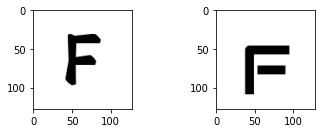

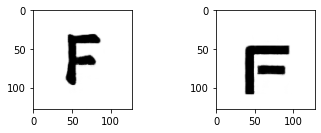

epoch: 121/150	g_loss: 32.730467	d_loss: 5.098659
epoch: 122/150	g_loss: 31.299814	d_loss: 5.203343
epoch: 123/150	g_loss: 31.621243	d_loss: 5.192549
epoch: 124/150	g_loss: 30.885859	d_loss: 5.267745
epoch: 125/150	g_loss: 31.056637	d_loss: 4.986151
epoch: 126/150	g_loss: 29.506608	d_loss: 5.150371
epoch: 127/150	g_loss: 29.680774	d_loss: 6.076602
epoch: 128/150	g_loss: 28.458975	d_loss: 5.982036
epoch: 129/150	g_loss: 28.883162	d_loss: 5.088933
epoch: 130/150	g_loss: 27.683377	d_loss: 5.487641
문자: G


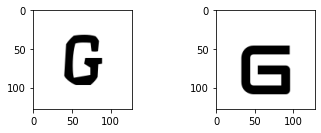

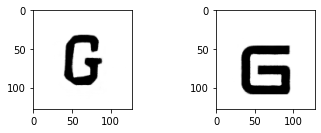

epoch: 131/150	g_loss: 27.622470	d_loss: 5.503269
epoch: 132/150	g_loss: 28.517265	d_loss: 5.133331
epoch: 133/150	g_loss: 26.810244	d_loss: 5.159792
epoch: 134/150	g_loss: 27.033011	d_loss: 5.256133
epoch: 135/150	g_loss: 27.492841	d_loss: 4.975369
epoch: 136/150	g_loss: 27.141594	d_loss: 5.210675
epoch: 137/150	g_loss: 26.177446	d_loss: 5.912700
epoch: 138/150	g_loss: 26.221570	d_loss: 5.737518
epoch: 139/150	g_loss: 26.303613	d_loss: 5.202151
epoch: 140/150	g_loss: 26.465581	d_loss: 5.636620
문자: W


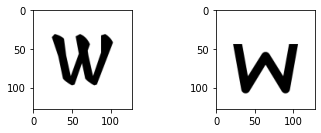

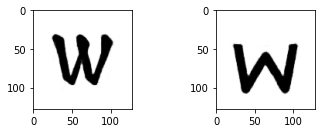

epoch: 141/150	g_loss: 25.306230	d_loss: 6.106520
epoch: 142/150	g_loss: 24.736605	d_loss: 5.286093
epoch: 143/150	g_loss: 24.829195	d_loss: 5.374120
epoch: 144/150	g_loss: 24.335693	d_loss: 5.350760
epoch: 145/150	g_loss: 24.259032	d_loss: 5.090580
epoch: 146/150	g_loss: 23.721008	d_loss: 5.156473
epoch: 147/150	g_loss: 23.392778	d_loss: 5.302954
epoch: 148/150	g_loss: 23.746436	d_loss: 5.047117
epoch: 149/150	g_loss: 23.806391	d_loss: 5.109406
epoch: 150/150	g_loss: 23.134847	d_loss: 6.272009
문자: s


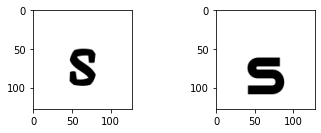

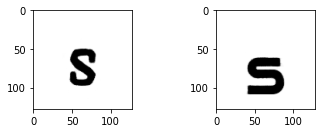

In [45]:
epochs = 150
batch_size = 30

ds = TensorDataset(x_data, t_data, t_meta, c_vec_t)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

encoder = Encoder().cuda()
decoder = Decoder().cuda()
discriminator = Discriminator(category_num=cg_num).cuda()

def generate(ch, style):
    encoder.eval()
    decoder.eval()
    discriminator.eval()

    x = torch.FloatTensor(source_tensor[ch]).view((1, 1, 128, 128)).cuda()
    c = torch.FloatTensor(c_vec[style]).view((1, 128, 1, 1)).cuda()
    # print(c.shape)
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach()
    # print(d_out.shape)
    # print(d_out)
    image = d_out.cpu()
    denorm_image = denorm_img(image)
    return image, denorm_image

def gprint(ch, s1, s2):
    g1, dg1 = generate(ch, s1)
    g2, dg2 = generate(ch, s2)
    # 생성된 사진이 너무 똑같이 나오길래 출력함
    # print('문자:',text[ch], '유사도:', (g1 == g2).float().mean())
    print('문자:',text[ch])
    ## 실제
    plt.title('Real')
    plt.subplot(221)
    plt.imshow(target_tensor[s1, ch], cmap='gray')
    plt.subplot(222)
    plt.imshow(target_tensor[s2, ch], cmap='gray')
    plt.show()
    # 생성
    plt.title('Fake')
    plt.subplot(221)
    plt.imshow(dg1.cpu().numpy()[0, 0], cmap='gray')
    plt.subplot(222)
    plt.imshow(dg2.cpu().numpy()[0, 0], cmap='gray')
    plt.show()

encoder.train()
decoder.train()
discriminator.train()

l1_criterion = nn.L1Loss().cuda()
bce_criterion = nn.BCEWithLogitsLoss().cuda()
ce_criterion = nn.CrossEntropyLoss().cuda()
mse_criterion = nn.MSELoss().cuda()

g_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)

L1_W = 500
MSE_W = 1000
# L1_W = 50
# MSE_W = 100


print('batch_size: %d, category_num: %d, font_num: %d'%(batch_size, cg_num, font_num))

log = []

for epoch in range(epochs):
    
    encoder.train()
    decoder.train()
    discriminator.train()

    d_total_loss = []
    g_total_loss = []

    l1_loss_arr = []
    ff_bce_loss_arr = []
    bce_loss_arr = []
    ce_loss_arr = []
    z_loss_arr = []

    for x, t, tm, c in loader:
        # print(x.shape, xm.shape, c.shape)

        cg = tm.T[0]
        font = tm.T[0]

        z, e_net = encoder(x)
        d_in = torch.cat((z, c), dim=1)
        d_out = decoder(d_in, e_net)
        # print(z.shape, d_in.shape, d_out.shape)

        # [debug]
        # plt.imshow(x.cpu()[0,0])
        # plt.show()
        # plt.imshow(t.cpu()[0,0])
        # plt.show()
        # print(tm[0])
        # print(c[0,0,0,0])

        real_tf, real_cg = discriminator(t)
        fake_tf, fake_cg = discriminator(d_out)

        # 정답 텐서
        one_tensor = torch.ones(x.shape[0], 1).cuda()
        zero_tensor = torch.zeros(x.shape[0], 1).cuda()

        # [dis] 가짜 검출 로스
        r_bce_loss = bce_criterion(real_tf, one_tensor)
        f_bce_loss = bce_criterion(fake_tf, zero_tensor)
        bce_loss = r_bce_loss + f_bce_loss
        
        # [dis] 카테고리 예측 로스
        category = torch.FloatTensor(np.array(np.eye(cg_num)[cg])).cuda() 
        # print(category.cpu()[0]) # [debug]
        r_ce_loss = bce_criterion(real_cg, category)
        f_ce_loss = bce_criterion(fake_cg, category) # 카테고리 예측 로스
        ce_loss = 0.5*(r_ce_loss + f_ce_loss)

        # [gen.en] z vector 유사도 로스
        t_z = encoder(t)[0]
        z_loss = mse_criterion(z, t_z)

        # [gen] 타겟 유사도 로스
        l1_loss = l1_criterion(d_out, t)
        # print(d_out.mean())

        # [gen] 변조 성공 로스
        ff_bce_loss = bce_criterion(fake_tf, one_tensor)

        # loss grad
        g_loss = (L1_W * l1_loss) + ff_bce_loss + (MSE_W * z_loss) + f_ce_loss
        d_loss = bce_loss + ce_loss

        # g_loss = ff_bce_loss + z_loss + f_ce_loss
        # d_loss = bce_loss + ce_loss

        # discriminator
        discriminator.zero_grad()
        d_loss.backward(retain_graph=True)

        # generator
        encoder.zero_grad()
        decoder.zero_grad()
        g_loss.backward(retain_graph=True)

        g_optimizer.step()
        # if epoch%2 == 0:
        d_optimizer.step()

        # log
        d_total_loss.append(d_loss.item())
        g_total_loss.append(g_loss.item())

        l1_loss_arr.append(l1_loss.item())
        ff_bce_loss_arr.append(ff_bce_loss.item())
        bce_loss_arr.append(bce_loss.item())
        ce_loss_arr.append(ce_loss.item())
        z_loss_arr.append(z_loss.item())

    log.append([d_total_loss, g_total_loss, l1_loss_arr, ff_bce_loss_arr, bce_loss_arr, ce_loss_arr, z_loss_arr])

    print('epoch: %d/%d\tg_loss: %f\td_loss: %f'%(epoch+1, epochs, sum(g_total_loss), sum(d_total_loss)))
    if (epoch+1) % 10 == 0:
        gprint(np.random.randint(0, source_tensor.shape[0]), 0, 1)

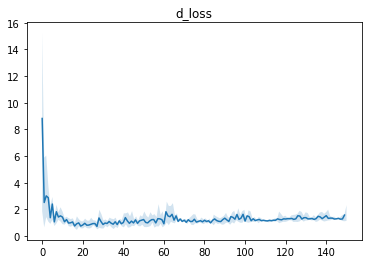

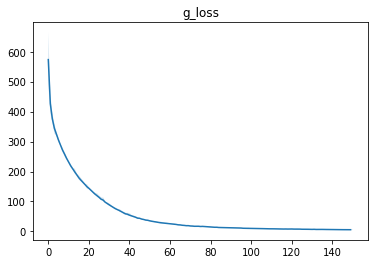

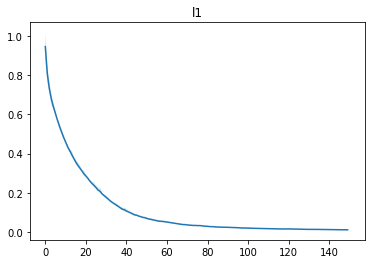

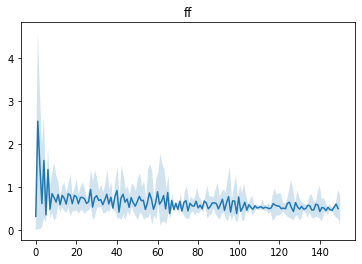

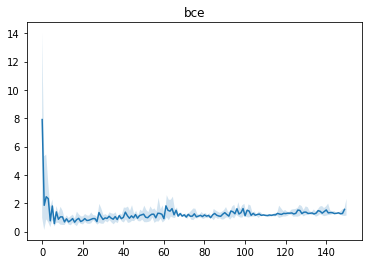

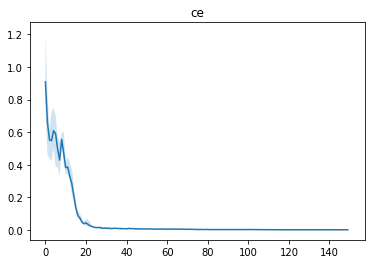

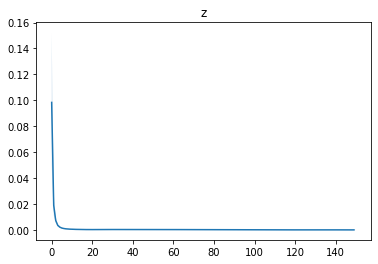

In [46]:
nlog = np.array(log).T.swapaxes(0,1)
n = ['d_loss','g_loss','l1', 'ff', 'bce', 'ce', 'z']
plt.tight_layout()
for i in range(len(n)):
    x = np.linspace(0, epochs, epochs)
    plt.title(n[i])
    y1 = nlog[i].max(0)
    y2 = nlog[i].min(0)
    plt.fill_between(x, y1, y2, where=(y1 > y2), alpha=0.2)
    plt.plot(nlog[i].mean(0))
    plt.show()

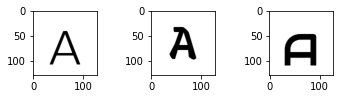

In [47]:
# source, target
plt.subplot(331)
plt.imshow(source[0], cmap='gray')
plt.subplot(332)
plt.imshow(target[0, 0], cmap='gray')
plt.subplot(333)
plt.imshow(target[1, 0], cmap='gray')
plt.show()

(2, 128, 1, 1)
distence: tensor([[140.0246]])


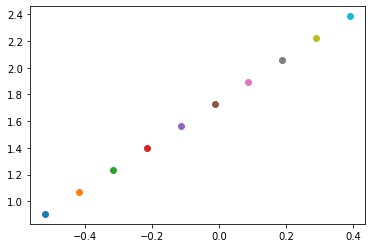

distence: tensor([[140.0246]])


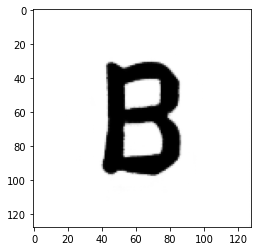

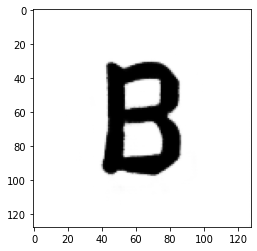

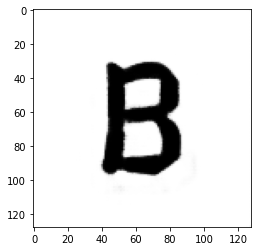

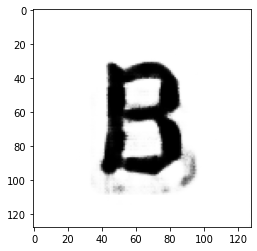

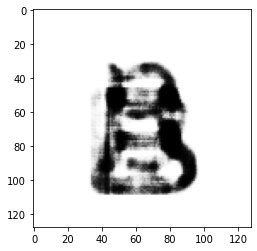

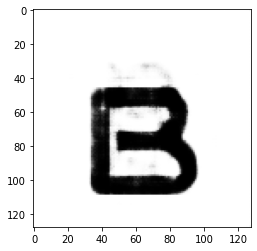

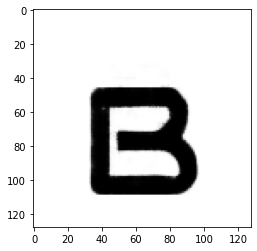

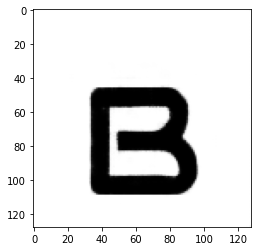

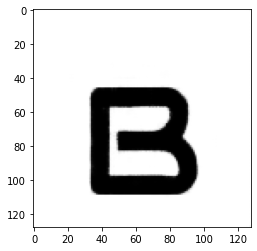

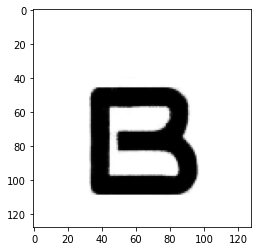

In [74]:
print(c_vec.shape)
c_units = torch.FloatTensor(c_vec.reshape(2, 1, 128))
torch.cdist(c_unit[0], c_unit[1])

# c_vec 조정가능
def custom_generate(ch, c_vec):
    encoder.eval()
    decoder.eval()
    discriminator.eval()

    x = torch.FloatTensor(source_tensor[ch]).view((1, 1, 128, 128)).cuda()
    c = torch.FloatTensor(c_vec).view((1, 128, 1, 1)).cuda()
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach()
    image = d_out.cpu()
    denorm_image = denorm_img(image)
    return image, denorm_image
def sub_distence(a, b, s):
    return a + (b - a) * s
# 스크롤 cvec 시각화
def print_scroll_vec(a, b, n=10):
    print('distence:', torch.cdist(a, b, 1))
    for i in range(n):
        sp = sub_distence(a, b, i/(n-1)).numpy()[0]
        plt.scatter(sp[0], sp[1]) # 표현상 0,1 두차원만으로 시각화
    plt.show()
# 스크롤 image 출력
def print_scroll_img(a, b, ch=0, n=10):
    print('distence:', torch.cdist(a, b, 1))
    arr = []
    for i in range(n):
        sp = sub_distence(a, b, i/(n-1)).numpy()[0]
        image, denorm_image = custom_generate(ch, sp.reshape(1, 128, 1, 1))
        plt.imshow(denorm_image[0,0], cmap='gray')
        plt.show()
        arr.append(denorm_image[0,0])
    return arr
print_scroll_vec(c_units[0], c_units[1], n=10)
image_arr = print_scroll_img(c_units[0], c_units[1], ch=1, n=10)

In [79]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()
plt.close()

ax.set_xlim((0, 128))
ax.set_ylim((0, 128))

im = ax.imshow(image_arr[0], cmap='gray')
def init():
    im.set_data(image_arr[0])
    return [im]
def animate(i):
    im.set_array(image_arr[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, interval=1000, blit=True)
rc('animation', html='jshtml')
anim

# 여기아래부터는 잡코드입니다.

In [49]:
# 실험 1
# vector = np.random.normal(size=(1, 128, 1, 1))
vector1 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector2 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector3 = torch.FloatTensor(np.random.normal(size=(1, 128)))

In [50]:
print(torch.cdist(vector1, vector2))
print(torch.cdist(vector1, vector3))

tensor([[16.1078]])
tensor([[14.5321]])


In [52]:
a = np.array([[-6,-2,-4]]) 
b = np.array([[1,3,2]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

print(0, c)
di = 1/3
print(1, c + (d - c) * di)
di = 2/3
print(2, c + (d - c) * di)
print(3, d)

print('distence:', torch.cdist(c, d, 2))

0 tensor([[-6., -2., -4.]])
1 tensor([[-3.6667, -0.3333, -2.0000]])
2 tensor([[-1.3333,  1.3333,  0.0000]])
3 tensor([[1., 3., 2.]])
distence: tensor([[10.4881]])


In [ ]:
a = np.array([[-1,-1]]) 
b = np.array([[1,1]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

def sub_distence(a, b, s):
    return a + (b - a) * s

print('distence:', torch.cdist(c, d, 1))
n = 4
for i in range(n):
    sp = sub_distence(c, d, i/(n-1)).numpy()[0]
    plt.scatter(sp[0], sp[1])
plt.show()

In [ ]:
# t
plt.imshow(target[1,1], cmap='gray')
plt.show()
plt.imshow(source[1], cmap='gray')
plt.show()